<a href="https://colab.research.google.com/github/anirbanmukherjee2709/tsai_end2.0_Session_5/blob/main/Session_05_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the dataset
%%shell
pip install google-trans-new
cd /content
path='/content/input'
comp='stanfordSentimentTreebank'

mkdir -p $path
mkdir -p /content/working/

wget -c 'http://nlp.stanford.edu/~socherr/'$comp'.zip' -O $comp'.zip'

# wget -c 'https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz'

unzip -q $comp.zip -d $path
# gunzip -c 'glove.6B.100d.txt.gz' > '/content/working/glove.6B.100d.txt'
rm -rf '/content/input/__MACOSX'

--2021-06-07 14:26:08--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-07 14:26:08--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  27.8MB/s    in 0.2s    

2021-06-07 14:26:08 (27.8 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [ ]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import time
import os

import torch, torchtext
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

import google_trans_new
from google_trans_new import google_translator

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Dataset

Setting up the dataset to incorporate labels with text

In [ ]:
DATA_PATH = '/content/input/stanfordSentimentTreebank'
WORK_PATH = '/content/working'

DATA_SET = 'datasetSentences.txt'
TRAIN_DEV_TEST = 'datasetSplit.txt'
PHRASE_DICT = 'dictionary.txt'
PHRASE_LABELS = 'sentiment_labels.txt'

def getRandomState():
    return np.random.RandomState(RANDOM_SEED)

# Create translator object
translator = google_translator()
available_langs = list(google_trans_new.LANGUAGES.keys())

In [ ]:
# Manual Seed
RANDOM_SEED = 43
torch.manual_seed(RANDOM_SEED)

# Declare Constants
PATH_CSV = '/content/tweets.csv'

NLP_AUG = [
    'random_insertion',
    'random_deletion',
    'random_swap',
    'translate'
]

RANDOM = getRandomState()

AUG_COUNT = 6 #arbitrary number can be increased or decreased. But needs to be an positive integer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Essential functions

In [ ]:
def clean_data(x):
    char_dict = {
        '-LRB-' : '(',
        '-RRB-' : ')',
        '\xa0' : ' ',
        '\xc2' : '',
        '\xc3\x83\xc2\xa0' : 'a',
        'à' : 'a',
        'Â' : '',
        'â' : 'a',
        'ã' : 'a',
        'Ã¡' : 'a',
        'Ã¢' : 'a',
        'Ã£' : 'a',
        'Ã¦' : 'ae',
        'Ã§' : 'c',
        'Ã¨' : 'e',
        'Ã©' : 'e',
        'Ã­' : 'i',
        'Ã¯' : 'i',
        'Ã±' : 'n',
        'Ã³' : 'o',
        'Ã´' : 'o',
        'Ã¶' : 'o',
        'Ã»' : 'u',
        'Ã¼' : 'u',
        'æ' : 'ae',
        'ç' : 'c',
        'è' : 'e',
        'é' : 'e',
        'í' : 'i',
        'ï' : 'i',
        'ñ' : 'n',
        'ó' : 'o',
        'ô' : 'o',
        'ö' : 'o',
        'û' : 'u',
        'ü' : 'u'
    }
    for keys in char_dict.keys():
        x = x.replace(keys, char_dict[keys])
    return x

def sentiment_for_phrases():
    # import phrase dictionary
    df_dictionary = pd.read_table(
        filepath_or_buffer = os.path.join(DATA_PATH, PHRASE_DICT)
        , header = None
    )
    df_dictionary = df_dictionary[0].str.split('|', expand=True)
    df_dictionary.columns = ['phrase', 'phrase_ids']

    # done to join it with the sentence dataset
    df_dictionary['sentence'] = df_dictionary['phrase'].apply(lambda x: clean_data(x))

    # import sentiments from 
    df_sentiment = pd.read_table(
        filepath_or_buffer = os.path.join(DATA_PATH, PHRASE_LABELS)
        , header = None
        , skiprows=1
    )
    df_sentiment = df_sentiment[0].str.split('|', expand=True)
    df_sentiment.columns = ['phrase_ids', 'sentiment_values']
    df_sentiment['sentiment_values'] = df_sentiment['sentiment_values'].astype('float32')
    df_sentiment['sentiment_5'] = df_sentiment['sentiment_values'].apply(lambda x: 5 if 0.8 < x <= 1.0 else 4 if 0.6 < x <= 0.8 else 3 if 0.4 < x <= 0.6 else 2 if 0.2 < x <= 0.4 else 1)
    df_sentiment['sentiment_25'] = df_sentiment['sentiment_values'].apply(lambda x: int(x*24+1))

    # merge and returm the sentiment dictionary
    return df_dictionary.merge(
        df_sentiment
        , how='inner'
        , on = 'phrase_ids'
    )

def import_and_create_split_mapping():
    # import the sentence dataset
    df_data_sentence = pd.read_table(os.path.join(DATA_PATH, DATA_SET))

    df_data_sentence['sentence'] = df_data_sentence['sentence'].apply(lambda x: clean_data(x))

    # import the train dev and test splits for each sentences
    train_dev_test_splits = pd.read_csv(os.path.join(DATA_PATH, TRAIN_DEV_TEST))

    train_dev_test_splits['splitset_label_2'] = train_dev_test_splits['splitset_label'].apply(lambda x: 'train' if x == 1 else 'valid' if x == 2 else 'test')

    return df_data_sentence.merge(
        train_dev_test_splits
        , how = 'inner'
        , on = 'sentence_index'
    )
    

In [ ]:
# import sentences from rotten tomatoes
df  = import_and_create_split_mapping()

# import processed sentiment dictionary
df_sentiment_dict = sentiment_for_phrases()

df_final = df.merge(
    df_sentiment_dict
    , how = 'inner'
    , on = 'sentence'
)

In [ ]:
(df_train, df_valid) = train_test_split(df_final, test_size=0.3, random_state=random.seed(RANDOM_SEED))

assert len(df_train) + len(df_valid) == len(df_final)

In [ ]:
(df_valid.columns, df_valid.index)

(Index(['sentence_index', 'sentence', 'splitset_label', 'splitset_label_2',
        'phrase', 'phrase_ids', 'sentiment_values', 'sentiment_5',
        'sentiment_25'],
       dtype='object'),
 Int64Index([ 9463, 10099,  7344,  3673,  4947,  8616,  9684,  9215,  1992,
               881,
             ...
             10176, 10359,  5858, 11329,  5414,  7102, 10672,  7778,  4470,
              3239],
            dtype='int64', length=3558))

Augmentation Functions

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def random_insertion(sentence, n=5): 
    words = remove_stopwords(sentence)
    words, sentence = words.split(), sentence.split() # Code added to tokenize
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if len(new_synonym) > 0:
            sentence.insert(random.randrange(len(sentence)), random.choice(new_synonym)) 
    return ' '.join(sentence)

def random_deletion(sentence, p=0.5):
    words = sentence.split() # Code added to tokenize
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return ' '.join([random.choice(words)])
    else:
        return ' '.join(remaining)

def random_swap(sentence, n=5):
    sentence = sentence.split() # Code added to tokenize
    length = range(len(sentence))
    if len(sentence) > 1:
        for _ in range(n):
            idx1, idx2 = random.sample(length, 2)
            sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return ' '.join(sentence)

def translate_and_back(sentence):
    trans_lang = random.choice(available_langs)
    translated = translator.translate(
        translator.translate(sentence, lang_tgt=trans_lang),
        lang_src=trans_lang,
        lang_tgt='en'
    )
    return translated

def augment_dataset(x, y1, y2):
    sentence_stack = []
    if AUG_COUNT > 0:
        aug_list = np.random.choice(NLP_AUG, size=AUG_COUNT, p=[0.33, 0.33, 0.33, 0.01])
        # np.random.randint(1, high=len(NLP_AUG) + 1, size=AUG_COUNT, dtype=int)
        
        for num_aug in aug_list:
            if   num_aug == NLP_AUG[0]:
                st = random_insertion(x, random.randint(0, int(len(x)/2)))
                sentence_stack.append((st, y1, y2))
            elif num_aug == NLP_AUG[1]:
                sentence_stack.append((random_deletion(x), y1, y2))
            elif num_aug == NLP_AUG[2]:
                st = random_swap(x, random.randint(0, int(len(x)/2)))
                sentence_stack.append((st, y1, y2))
            elif num_aug == NLP_AUG[3]:
                sentence_stack.append((translate_and_back(x), y1, y2))

    return sentence_stack

# Create Augmentation

Create different augmentation for each of the tweets and pass it wil the same label

In [ ]:
df_aug = pd.DataFrame()
for idx in df_train.index:
    aug_df = pd.DataFrame(
        augment_dataset(df_train['sentence'][idx], df_train['sentiment_5'][idx], df_train['sentiment_25'][idx]),
        columns=['sentence','sentiment_5', 'sentiment_25']
    )
    df_aug = df_aug.append(aug_df)

assert len(df_train) * (AUG_COUNT) == len(df_aug)

In [ ]:
# create a single dataset of the augmented and original data
df_new = df_train.append(df_aug[['sentence', 'sentiment_5', 'sentiment_25']])
df_new.reset_index(drop=True,inplace=True)

assert len(df_train) * (AUG_COUNT + 1) == len(df_new)

# Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [ ]:
sentence = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)
# label25 = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [ ]:
fields = [('sentence', sentence),('sentiment_5', label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [ ]:
train = [data.Example.fromlist([df_new.sentence[i], df_new.sentiment_5[i]], fields) for i in range(df_new.shape[0])]
valid = [data.Example.fromlist([df_valid.sentence[i], df_valid.sentiment_5[i]], fields) for i in df_valid.index]

In [ ]:
# Creating dataset
train = data.Dataset(train, fields)
valid = data.Dataset(valid, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [ ]:
(len(train), len(valid))

(58100, 3558)

An example from the dataset:

In [ ]:
vars(train.examples[random.randint(0, df_new.shape[0])])

{'sentence': ['photographic',
  'marvel',
  'of',
  'sorts',
  'and',
  'record',
  'of',
  'that',
  'fishy'],
 'sentiment_5': 4}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:

In [ ]:
sentence.build_vocab(train)
label.build_vocab(train)
# label25.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [ ]:
print('Size of input vocab : ', len(sentence.vocab))
print('Size of label5 vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(sentence.vocab.freqs.most_common(10)))
print('Labels 5 : ', label.vocab.stoi)

Size of input vocab :  30192
Size of label5 vocab :  5
Top 10 words appreared repeatedly : [('.', 47183), (',', 42108), ('the', 37804), ('of', 28633), ('a', 27623), ('and', 26435), ('to', 18408), ('-', 16230), ('is', 14866), ("'s", 14452)]
Labels 5 :  defaultdict(None, {4: 0, 2: 1, 3: 2, 5: 3, 1: 4})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(sentence.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [ ]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                        #    bidirectional=True,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # self.fc25 = nn.Linear(hidden_dim, output_dim[1])
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)

        # dense_outputs25 = self.fc25(hidden)
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)

        # output25 = F.softmax(dense_outputs25[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 4
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(30192, 300)
  (encoder): LSTM(300, 100, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 9,461,305 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [ ]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# criterion25 = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)
# criterion25 = criterion25.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0

    # epoch_loss25 = 0
    # epoch_acc25 = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.sentiment_5)
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.sentiment_5)
        
        # backpropage the loss and compute the gradients
        loss.backward(retain_graph=True)      
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item() 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.sentiment_5)
            acc = binary_accuracy(predictions, batch.sentiment_5)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [ ]:
N_EPOCHS = 40
best_valid_loss = float('inf')
val_losses = []
train_losses = []

val_accuracy = []
train_accuracy = []

for epoch in range(N_EPOCHS):
     
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)


    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch {epoch+1} | Time Taken: {(time.time() - start_time):.2f}s')
    print(f'\tTrain Loss  5 labels: {train_loss:.3f} | Train Acc  5 labels: {train_acc*100:.2f}%')
    print(f'\t Val. Loss  5 labels: {valid_loss:.3f} |  Val. Acc  5 labels: {valid_acc*100:.2f}% \n')

Epoch 1 | Time Taken: 20.04s
	Train Loss  5 labels: 1.573 | Train Acc  5 labels: 29.51%
	 Val. Loss  5 labels: 1.555 |  Val. Acc  5 labels: 32.48% 

Epoch 2 | Time Taken: 19.88s
	Train Loss  5 labels: 1.512 | Train Acc  5 labels: 38.61%
	 Val. Loss  5 labels: 1.536 |  Val. Acc  5 labels: 34.90% 

Epoch 3 | Time Taken: 19.98s
	Train Loss  5 labels: 1.460 | Train Acc  5 labels: 44.09%
	 Val. Loss  5 labels: 1.530 |  Val. Acc  5 labels: 35.10% 

Epoch 4 | Time Taken: 19.86s
	Train Loss  5 labels: 1.421 | Train Acc  5 labels: 48.33%
	 Val. Loss  5 labels: 1.534 |  Val. Acc  5 labels: 34.51% 

Epoch 5 | Time Taken: 19.79s
	Train Loss  5 labels: 1.386 | Train Acc  5 labels: 52.27%
	 Val. Loss  5 labels: 1.536 |  Val. Acc  5 labels: 34.66% 

Epoch 6 | Time Taken: 19.86s
	Train Loss  5 labels: 1.355 | Train Acc  5 labels: 55.57%
	 Val. Loss  5 labels: 1.540 |  Val. Acc  5 labels: 34.13% 

Epoch 7 | Time Taken: 19.87s
	Train Loss  5 labels: 1.328 | Train Acc  5 labels: 58.27%
	 Val. Loss  5 lab

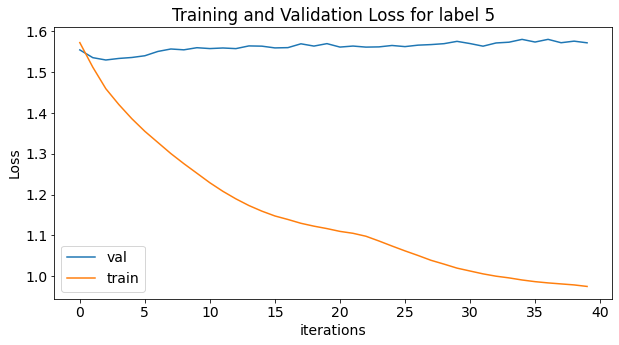

In [ ]:
# Plotting the train and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss for label 5")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

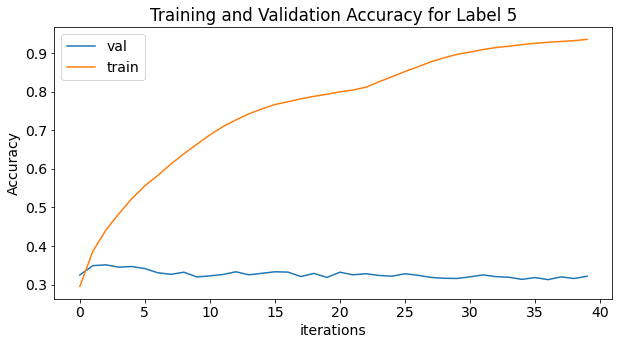

In [ ]:
# Plotting the train and validation Accuracy

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy for Label 5")
plt.plot(val_accuracy, label="val")
plt.plot(train_accuracy, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

categories = {1: "very negative", 2:"negative", 3:"neutral", 4:'positive', 5:'very positive'}
inv_categories = {v: k for k,v in categories.items()}

def classify_tweet(sentence):
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()+1]

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'very negative'

In [ ]:
df_eval = pd.DataFrame(
    [(df_valid['sentence'][idx], df_valid['sentiment_5'][idx], inv_categories[classify_tweet(df_valid['sentence'][idx])]) for idx in df_valid.index]
    , columns=['sentence','sentiment_5', 'sentiment_5_c']
)

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_eval['sentiment_5'].values, df_eval['sentiment_5_c'].values, average='weighted')

0.17384804637795392

In [ ]:
# not matching
df_incorrect = df_eval[df_eval['sentiment_5'] != df_eval['sentiment_5_c']]
df_incorrect

,sentence,sentiment_5,sentiment_5_c
0,I firmly believe that a good video game movie ...,4,2
3,"Fast and funny , an action cartoon that 's sus...",4,2
4,"Exhilarating , funny and fun .",5,1
8,The entire movie establishes a wonderfully cre...,5,1
9,Often moving and explores the discomfort inher...,3,2
...,...,...,...
3552,An indispensable peek at the art and the agony...,4,1
3553,Tries so hard to be quirky and funny that the ...,1,2
3554,I liked the original short story but this movi...,1,2
3556,It 's a hoot watching The Rock chomp on jumbo ...,5,1


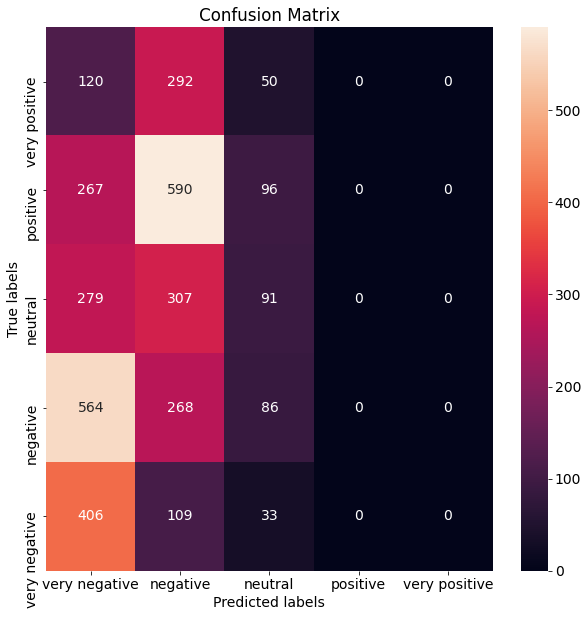

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_eval['sentiment_5'].values, df_eval['sentiment_5_c'].values)

import seaborn as sns
import matplotlib.pyplot as plt     


font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(categories.values())); ax.yaxis.set_ticklabels(list(categories.values())[::-1]);